In [ ]:
### Optional cell for DCML users tests: the following libraries are needed to 
### be installed for the library to work. Run this cell to install them if they
### are not yet. Maybe you'll have to replace `pip` by `pip3` or the conda install 
### command depending how you have python3 ready to be used on you machine.

!pip install music21
!pip install pretty_midi
!pip install madmom
!pip install matplotlib

This tutorial showcases how to draw a single wavescape using the "single_wavescape" function from the "wavescapes" python module. All the different parameters and customization options from this function are presented with meaningful examples. The goal of this tutorial is only to show how to use the library; for explanations of the visualization's methodology and how to interpret wavescapes, please refer to [the official publication from Musicae Scientiae (dead link as it is not yet published)](dead)

Before beginning, be sure the module "wavescapes" and all its dependencies are properly installed on your machine or virtual environnement ( `pip install wavescapes`). ( _Note for DCML users tests: step not required as long as you are running this notebook on a local clone of the repo_ ). Run the cell below to check if the module was properly installed. 

In [1]:
'''
The shell line below will be removed once the last version of the library 
is publicly available through pip. Its purpose for now is just to redirect
the source code of the repo in the same place as this notebook.
'''
!ln -s ../wavescapes wavescapes

from wavescapes import single_wavescape

ln: wavescapes/wavescapes: File exists


All examples in this notebook are computed from the same input file, which is the _Prelude in C Major_ from J. S. Bach (BWV 846). The version used in this repository comes from this [publicly available transcription in XML format](https://musescore.com/classicman/scores/210606) and is already downloaded and ready to use in the "inputs" folder located in the same directory as this notebook. The line below checks if the file is present and loads its path in the 'bach_prelude_fp' variable which is used throughout this notebook.

In [2]:
import os

bach_prelude_fp = 'inputs/Prelude_No._1_BWV_846_in_C_Major.mxl'

if not os.path.isfile(bach_prelude_fp):
    raise Exception("'%s' does not exist."%bach_prelude_fp)

The library accepts two types of inputs: symbolic data and real audio data. Audio processing for wavescapes is explained in details in the tutorial notebook number 2, hence this notebook focuses solely on symbolic data in MIDI format, or XML/XML/MusicXML formats. The library acts the same way regardless of the symbolic data format, which is why we only show examples obtained from an XML file.

For ease of navigation, here is the table of contents with skiplinks to directly get to the different parts presented in this notebook. If it is your first time with the library, we strongly recommand you follow this notebook in sequential order, running each cell one after the other.

# Table of Contents

1. [Base case](#base)
    1. Select an analysis window length (and its implication for the resulting plot)
2. [Horizontal ticks for bar number](#horizontalticks)
    1. “tick_ratio” as a measure of wavescape's element per tick
    2. “tick_offset” as a way to account the 0th bar
    3. "tick_factor" as a way to scale the number of ticks
3. [Vertical indicators for hierarchical markers](#verticalticks)
    1. “indicator_size” as a factor of size for vertical markers
4. [Highlight & partitioning](#highlights)
    1. Producing “subwavescapes”
    2. Drawing multiples highlights on a single wavescape
5. [Cosmetic changes](#comsetic)
    1. Adding line delimiters between primitives
    2. Different drawing primitives (rhombus, diamonds, and hexagons)
    3. True Opacity and its caveat
    4. Adding a label on the top left corner
7. [Other parameters](#other)
    1. Saving
    2. Adding a wavescape as a matplotlib subfigure
    3. Triming silences at both extremeties of the piece
    4. Removing tracks/parts that are unpitched

<a id='base'></a>
# 1. Base case

The function `generate_single_wavescap` takes three mandatory arguments:

* `filepath`, a string representing the path of the input file.
* `pixel_width`, an integer representing the width in pixel of the resulting plot, assuming a DPI of 96.
* `coefficient`, a positive integer ranging from 1 to 6 which is the Fourier coefficient to be displayed in the plot.

Although not mandatory, the parameter `aw_size`, a float, should often be specified as it represents the _size_ of the _analysis window_ which corresponds to the size of the shortest segments of the wavescapes (the ones that fill to bottom-most row). The unit of this argument for symbolic data is a quarter note, and by default, is set to 1.0, meaning the input score is segmented in `N` non-overlapping segments of quarter notes length. The wavescapes feature `0.5*N^2` individually drawn elements, so `aw_size` **is crucial to the performance of the algorithm, the smaller its value is, the more sharp the visual plot produced is, but bigger is the time taken to generate it**.

The line below thus generates the wavescape of the fifth coefficient on Bach's Prelude with a width of 500 pixels, and an analysis window's default size of one quarter note.

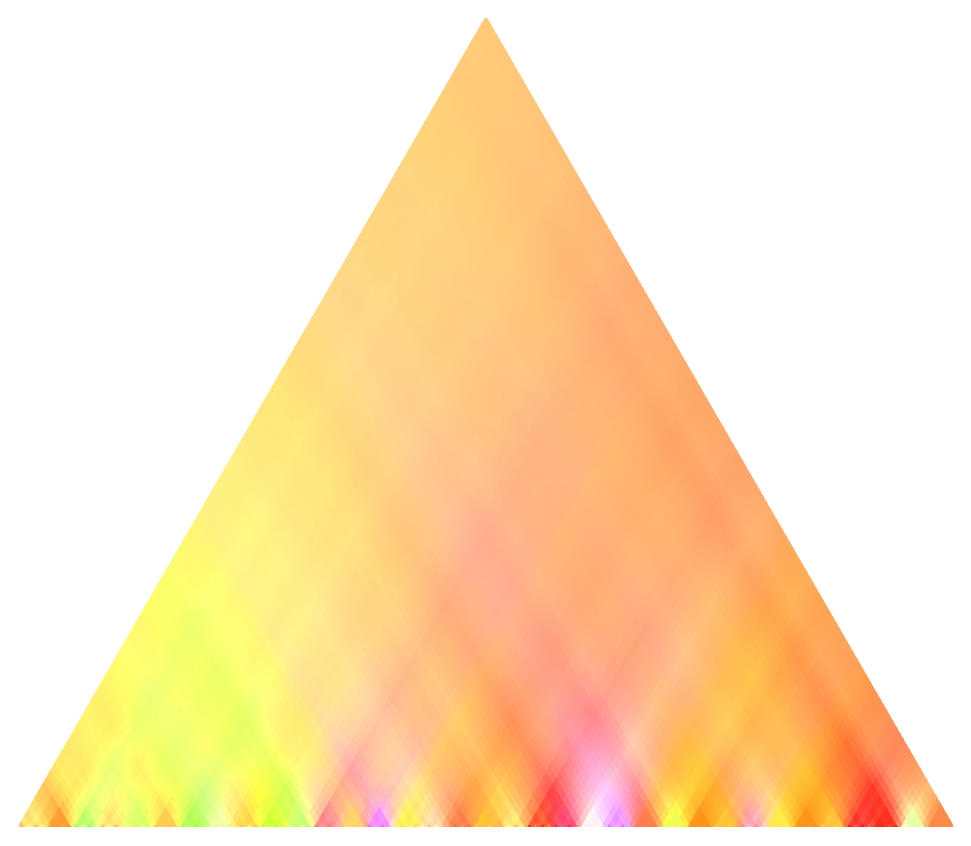

In [3]:
single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5)

If we want to have the visual resolution of one color per bar, the value of 4.0 needs to be given to `aw_size`, as the time signature of the Prelude is 4/4, i.e. 4 quarter notes per bar: 

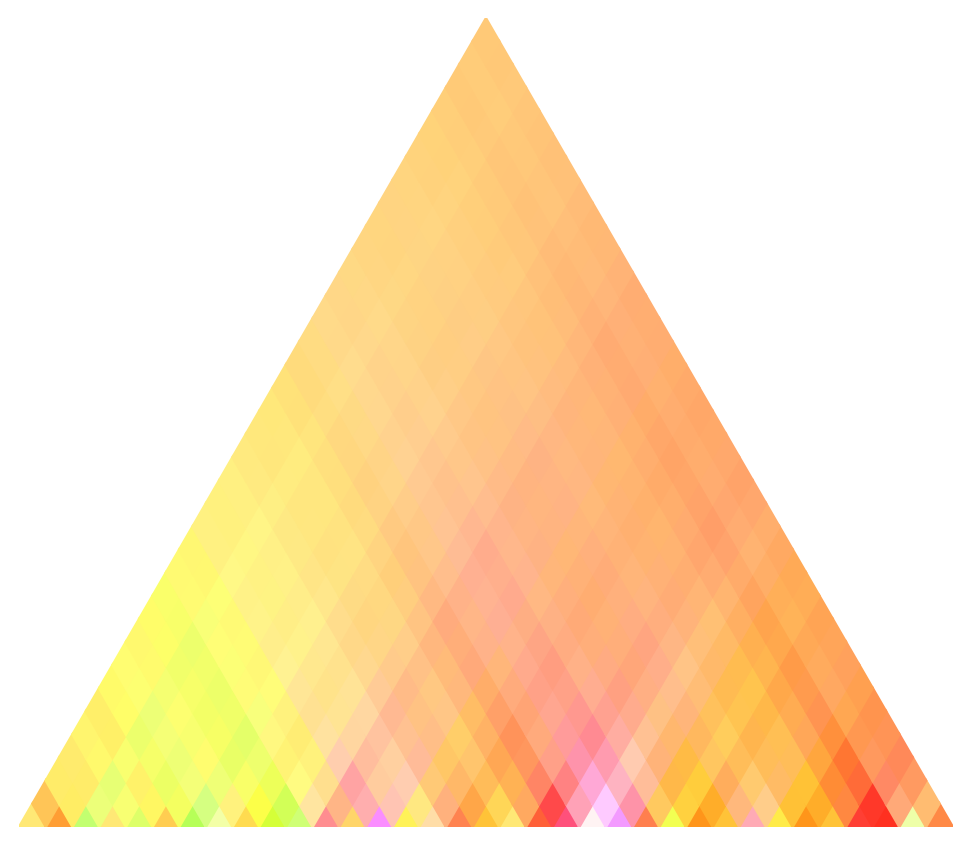

In [4]:
single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5, aw_size=4.0)

<a id='horizontalticks'></a>
# 2. Horizontal ticks for bar number

Without horizontal markers, it can be hard to understand to which section of the piece a certain color in the plot corresponds to. The parameter `tick_ratio`, a positive integer, exists to solve this problem: It represents after how many "chunks" from the bottom-most row one tick needs to be drawn on the horizontal axis (in other word, the _ratio_ of analysis window per _tick_ ). By default this parameter is set to `None`, which means no horizontal ticks have to be displayed by the function.

If for example, we want each tick to represent a bar in the Prelude in C Major, by knowing its time signature is 4/4, and considering the default analysis window of one quarter note, `tick_ratio` with a value of 4 draws a tick per bar of the Prelude:

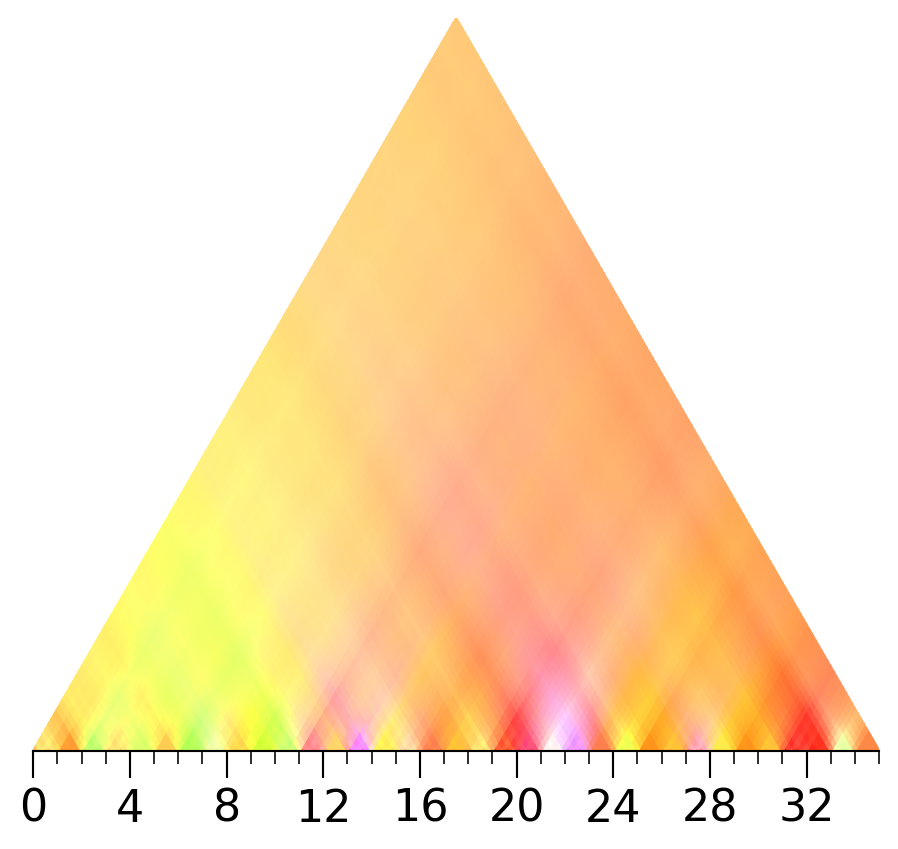

In [5]:
single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5, tick_ratio=4)

Although the placement of the ticks are accurate to the bars from the music score, the first bar in scores is numbered 1, not 0. Setting `tick_offset`, another parameter of the function to the value 0 makes the tick's numbers starts at 1:

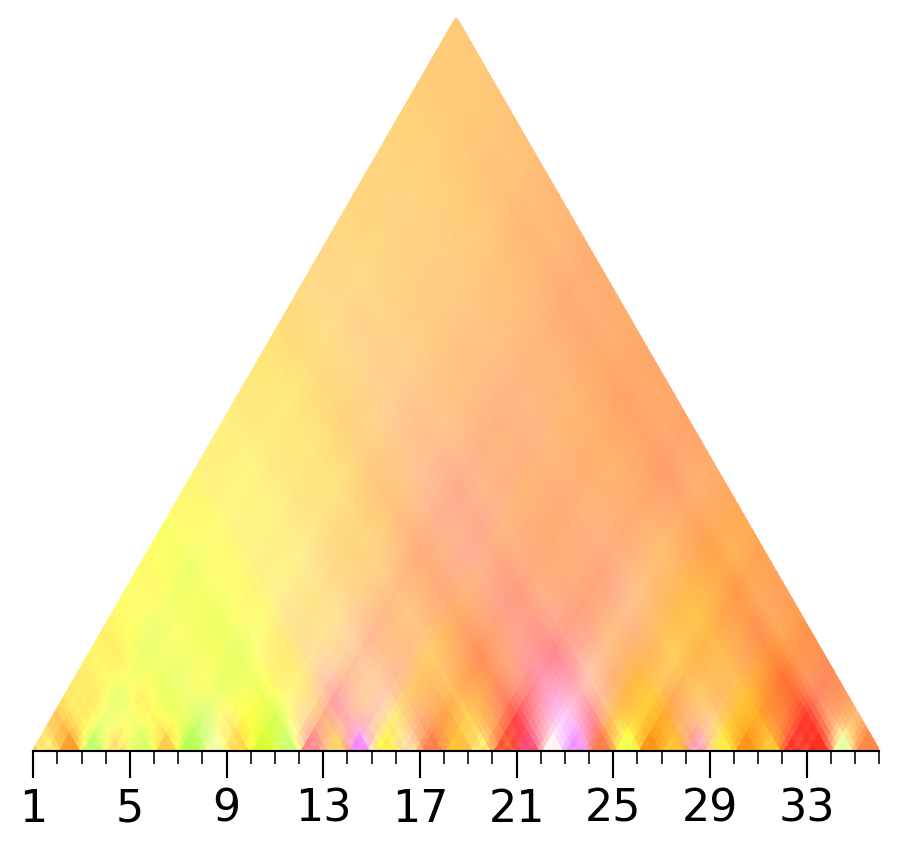

In [6]:
single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5, tick_ratio=4, tick_offset=0)

This parameter serves more purpose than indicating to the function to start ticks at 1: `tick_offset` is a positive integer whose range from 0 until `tick_ratio` and indicates how much amount of analysis_windows have to be offset before the first tick. This permits the modelisation of pieces that have "pick-up bars" or "anacruses", i.e. notes played before the start of the first bar. By default this parameter has value `None` which as seen previously, means the tick numbers start at 0.

Let's imagine that the Prelude in C Major is shifted by a half note to the left, and thus begins one half note before the first bar. To correctly represents the placement of the bars in the wavescape, the value of 2 can be given to `tick_offset` which the function interprets as _offsetting_ the _ticks_ by two amounts of analysis window (since the analysis window is one quarter note, and two quarter notes forms a half note):

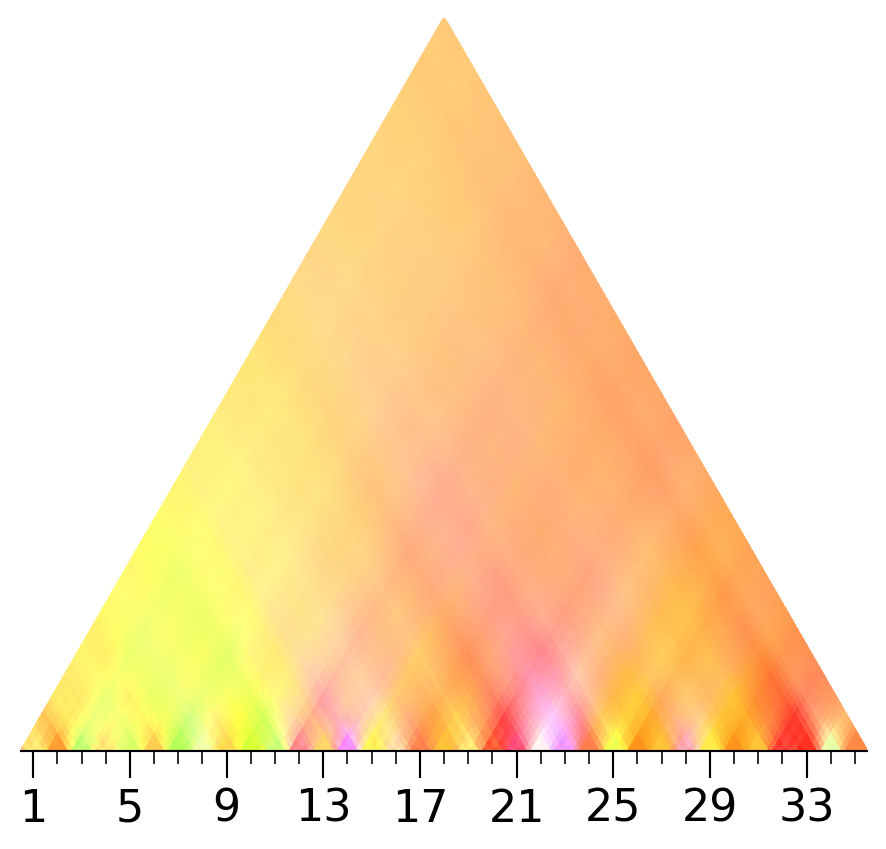

In [7]:
single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5, tick_ratio=4, tick_offset=2)

A third parameter, `tick_factor`, a positive float whose default value is 1.0, serves as a way to _factor_ the number displayed on _ticks_. Let's say we want to have one tick per quarter note on the Prelude, by setting `tick_ratio` and `aw_size` both to one:

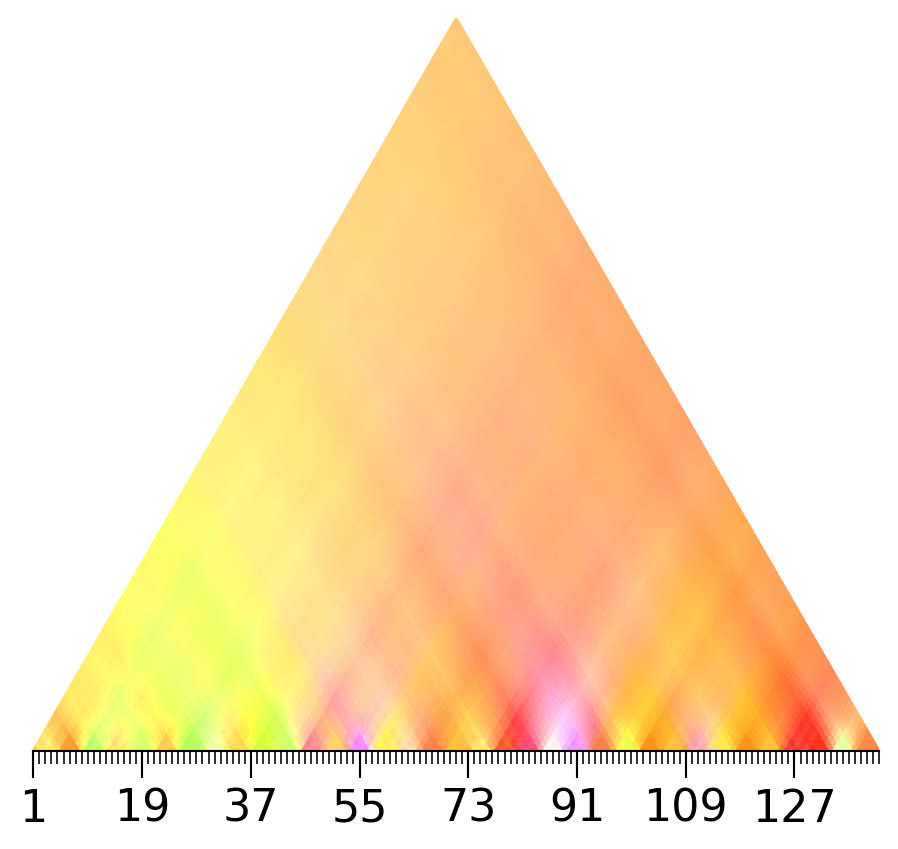

In [8]:
single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5, aw_size=1, tick_ratio=1, tick_offset=0)

The ticks now represent now the number of quarter note, but what if we want the number to still represent bar numbers, not quarter notes number? This can be achieved in this case by setting `tick_factor` to 0.25 (i.e. 1/4) to scale the number displayed on the ticks by one fourth:

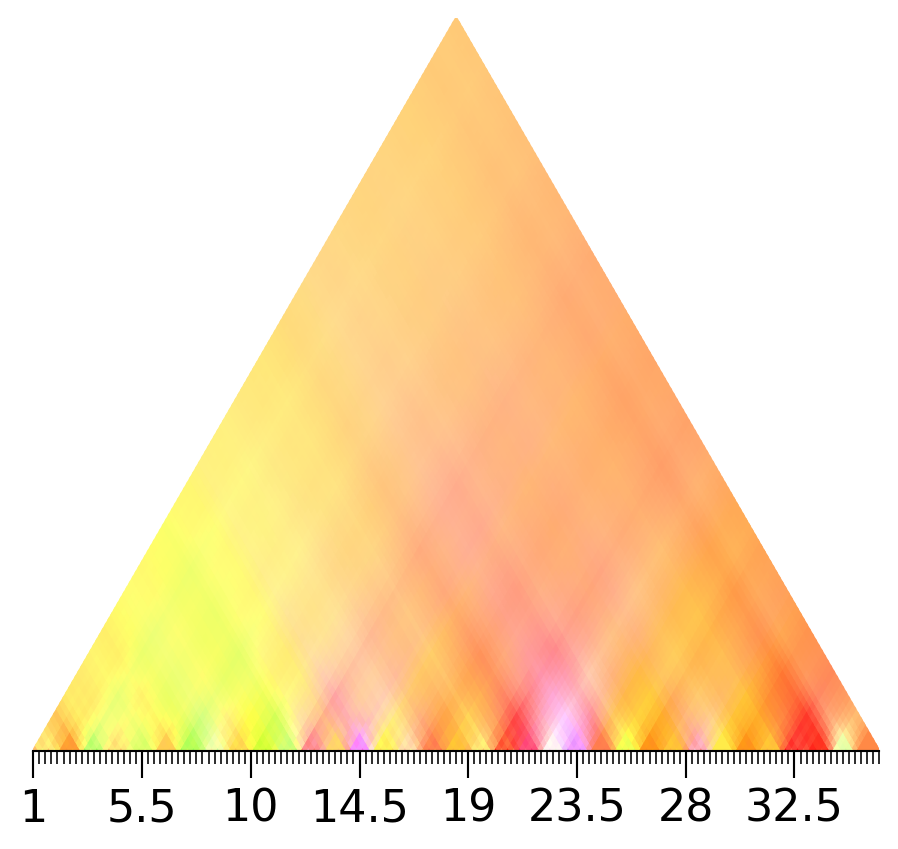

In [9]:
single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5,\
                          aw_size=1, tick_ratio=1, tick_offset=0, tick_factor=0.25)

This works also the other way around, if we have `aw_size` set to 8 (two bars in this case) and `tick_ratio` to 1, we have one tick per two bars, but having the number representing the bars is possible by _factoring_ the _tick_ numbers by 2:

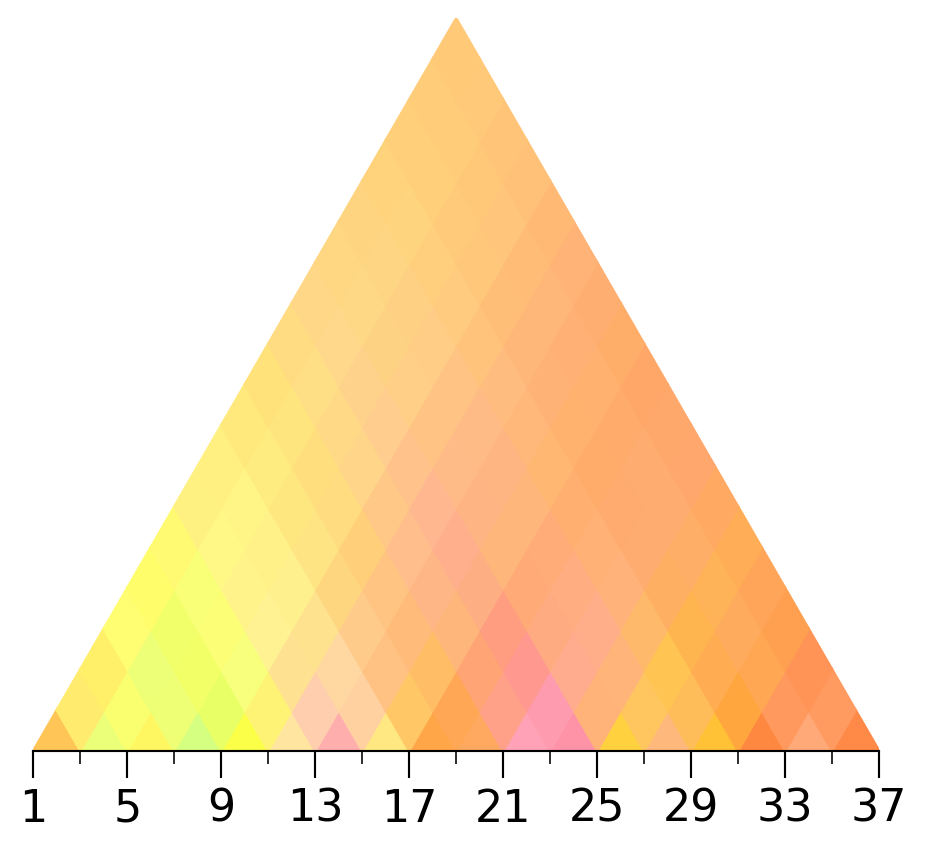

In [10]:
single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5,\
                          aw_size=8, tick_ratio=1, tick_offset=0, tick_factor=2)

<a id='verticalticks'></a>
# 3. Vertical indicators for hierarchical markers

In a similar fashion horizontal ticks are useful to understand the time placement of certain colors, vertical indicators can help grasp the hierarchical levels of the different rows from a wavescape.

The parameter `indicator_size`, a positive float, exists for this purpose. Its default value is `None` which the function interprets as "do not to display such indicators". Otherwise the recommanded value is 1.0, and represents the relative size of 7 rounded indicators that are put on each side of the wavescape. They are placed at each eight subdivision of the length of the side of the wavescape: 

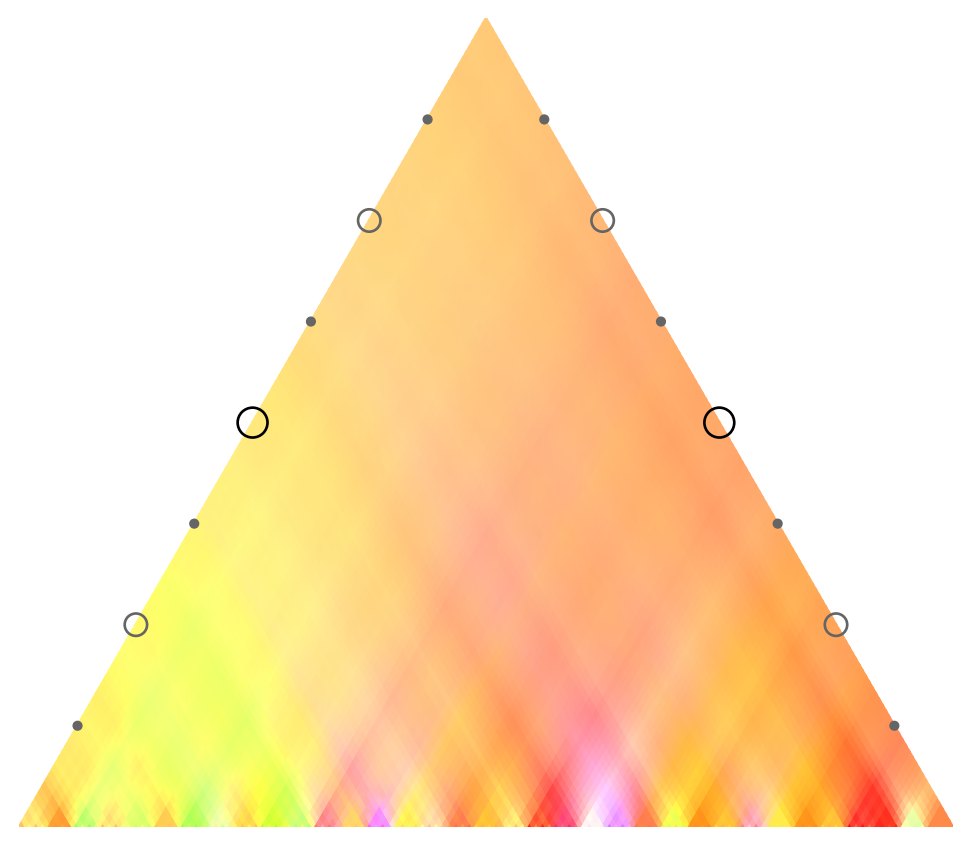

In [11]:
single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5, indicator_size=1.0)

The biggest indicator is the middle one, the black circle, whose center represents the hierarchical level of all segments whose length is half the length of the piece. The two smaller gray circle represent from bottom to top, the levels of segments of 1/4 and 3/4 the length of the piece, while the 4 remaining indicators represent the levels of segements of 1/8, 3/8, 5/8 and 7/8 the length of the piece respectively.

Decreasing (resp. increasing) the value of `indicator_size` decreases (resp. increases) the relative radius of each of those indicator:

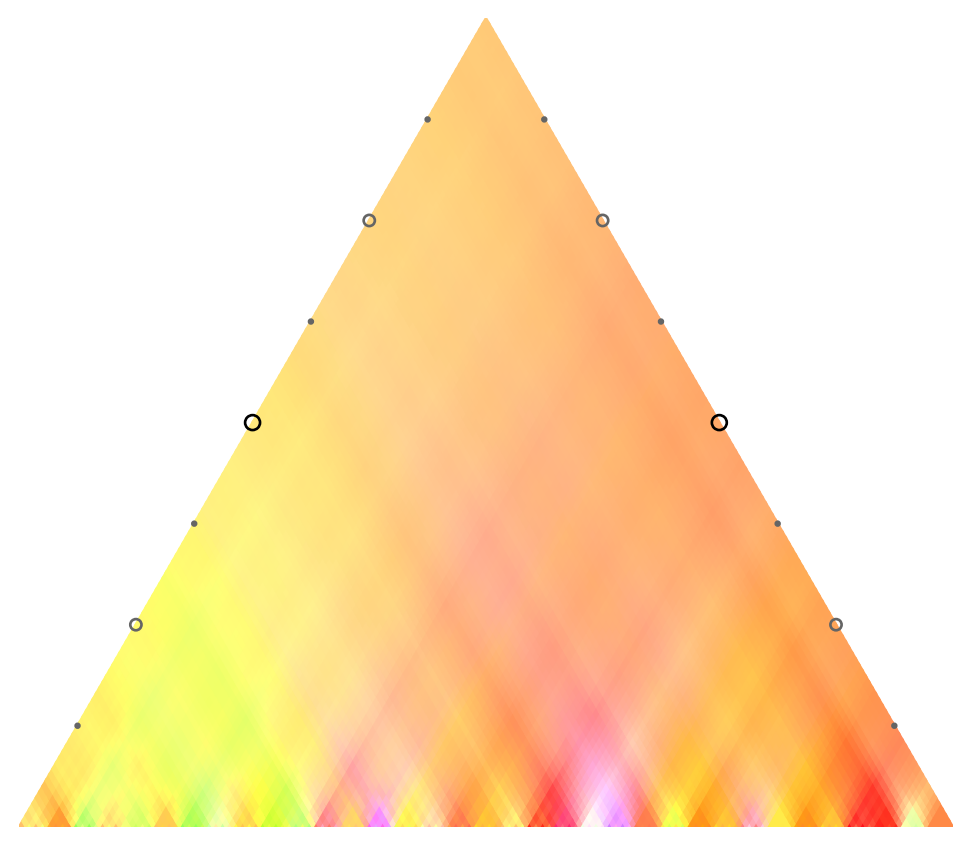

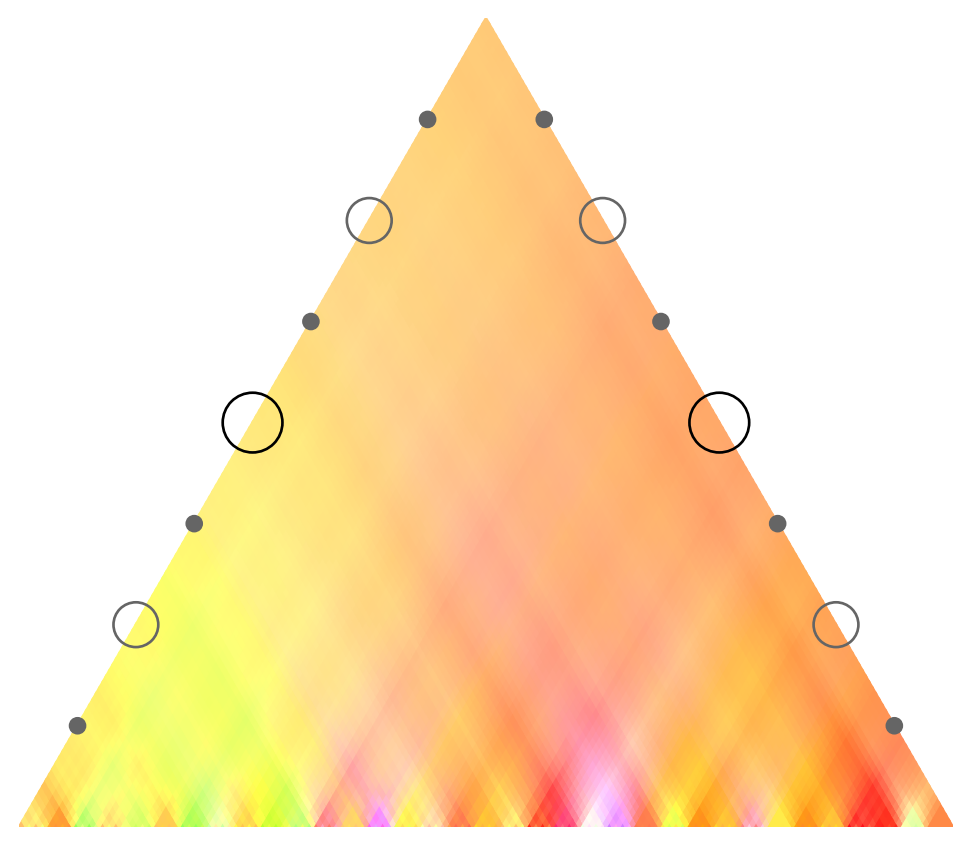

In [12]:
single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5, indicator_size=0.5)
single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5, indicator_size=2)

<a id='highlights'></a>
# 4. Highlights & partitioning

### "zoom-in"

Sometimes it can be useful to "zoom in" on a particular part of the wavescape in order to more easily see all individual colored elements. The parameter `subparts_highlighted` exists partly for this purpose. It expects an 1x2 array or tuples of integer, which represent the onset and offset of the part to be "zoomed-in" in terms of index of analysis window. 

For instance, let's say we want to observe more closely the region from bar 19 to 24, as it is the only part of the wavescape that features white. If we keep the analysis window size to one quarter note, that means we want to observe the sub region from the 72th (`(19-1)* 4`) segment to the 96th, thus the value `[72, 96]` can be given to `subparts_highlighted` for zooming in on this particular _subpart_ of the piece:

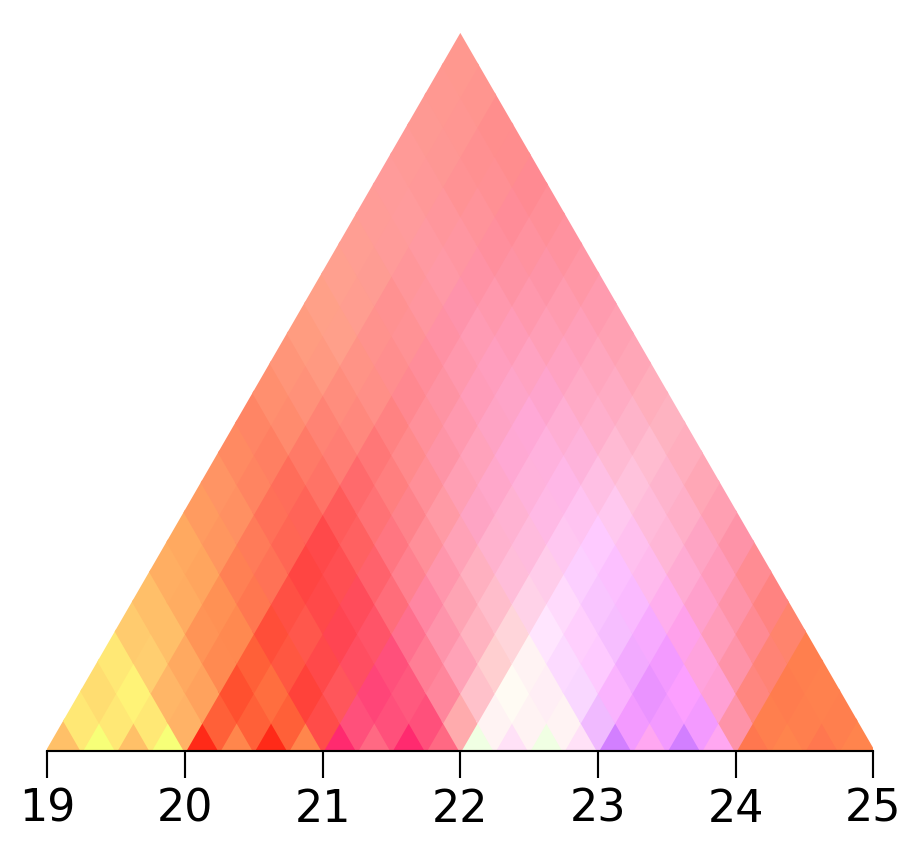

In [13]:
single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5,\
                          tick_ratio=4, tick_offset=0, subparts_highlighted=[72,96])

As can be seen, if the parameters relating to the ticks are provided, they stay consistent with the zoom-in. However, note that the vertical indicators for the hierarchical level do not work with this feature.

### Highlights

The parameter `subparts_highlighted` also can receive a list of regions (still in onset-offset tuple fashion) and displays highlights over those regions by the means of black outlines. For instance, let's highlight the region on which we just zoomed in and the first two bars of the Prelude by providing the value `[[0,8], [72,96]]` to the parameter:

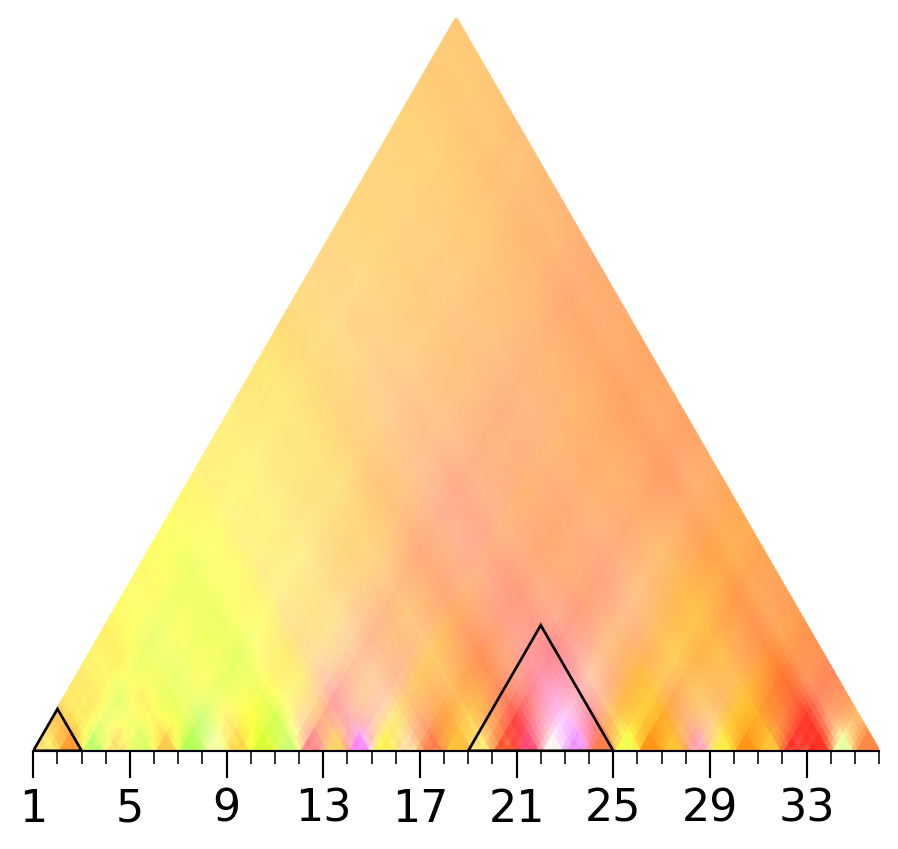

In [14]:
single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5,\
                          tick_ratio=4, tick_offset=0, subparts_highlighted=[[0,8],[72,96]])

As many tuples as wanted in any order can be given in this list, and the zones they represent can overlap without restriction:

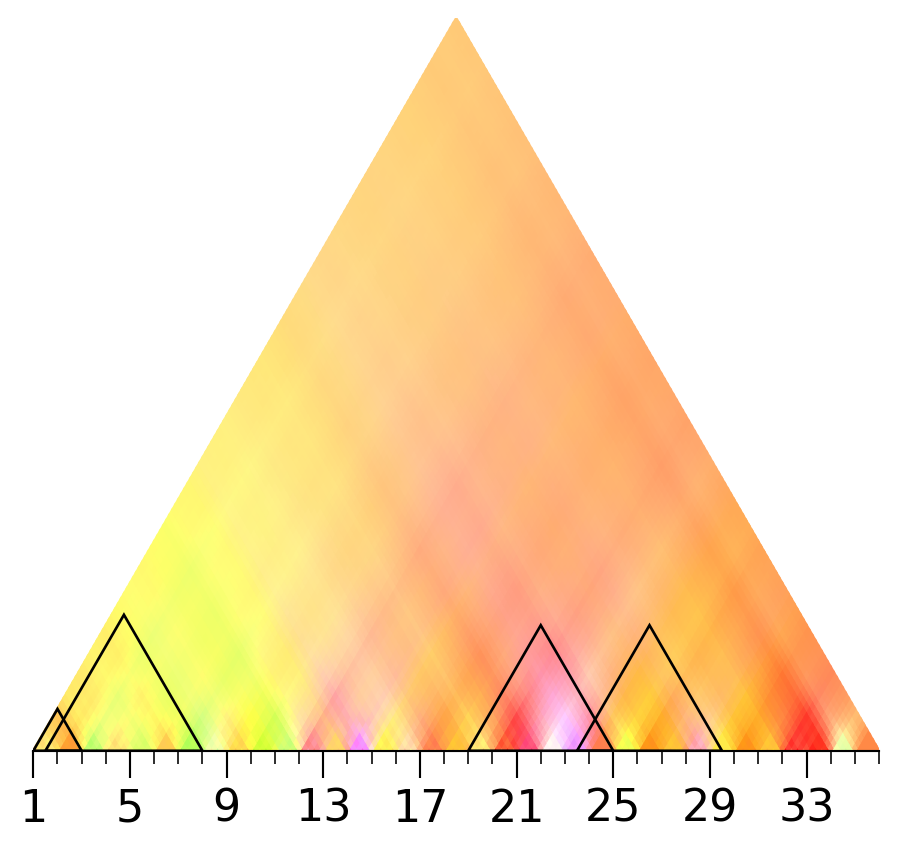

In [15]:
single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5,\
                          tick_ratio=4, tick_offset=0, subparts_highlighted=[[0,8],[72,96],[2,28],[90,114]])

<a id='cosmetic'></a>
# 5. Cosmetic changes

Some parameters in this library exist for cosmetic reasons, without bringing any analytical insight: 

### Adding outlines & changing the drawing primitive

The first is `add_line`, which as its name indicates, add an outline on all the elements (often called 'primitive'here) of the wavescape. It expects a positive float/integer, and represents the width of the outline to be drawn. Its default value is None (meaning no outlines to be drawn).

Then there is `drawing_primtive` which dictates what shape each elements of the wavescape is drawn in. Three values are supported yet:

1. 'rhombus': default value, its the name of a diamond that is formed by the union of two equilateral triangles. Makes the whole wavescape plot into the shape of an equilateral triangle.

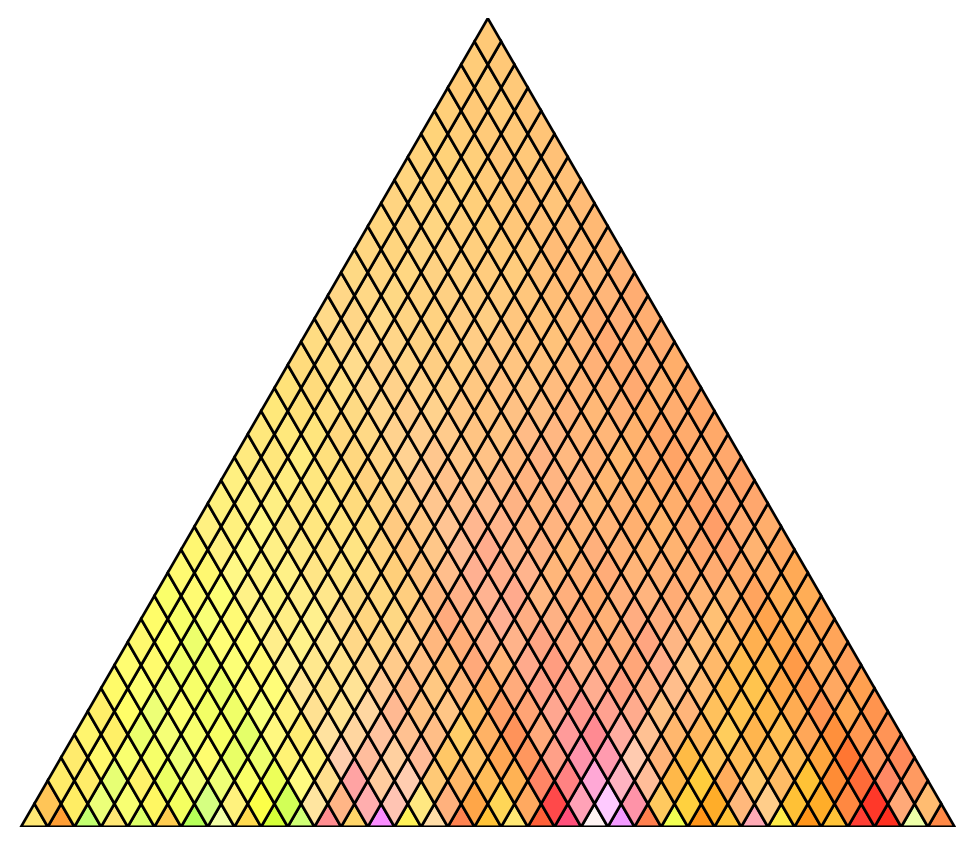

In [16]:
single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5,\
                          aw_size=4, drawing_primitive='rhombus', add_line=1)

2. 'diamond': diamond that is twice as tall as it is wide. Can be useful to give more visual weight to the vertical hierarchy of the plot.

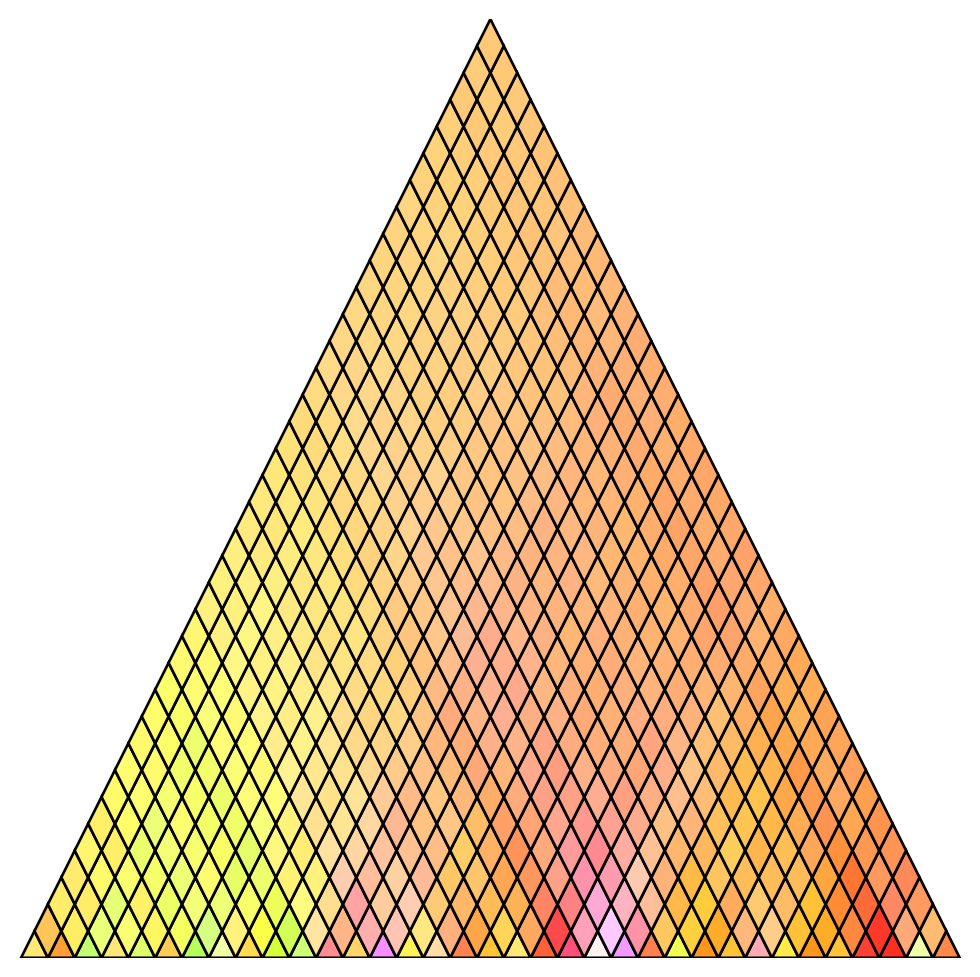

In [17]:
single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5,\
                          aw_size=4, drawing_primitive='diamond', add_line=1)

3. 'hexagon': pretty self-explanatory, the shape of the hexagon allow individual colors from the rows to be more easily observable.

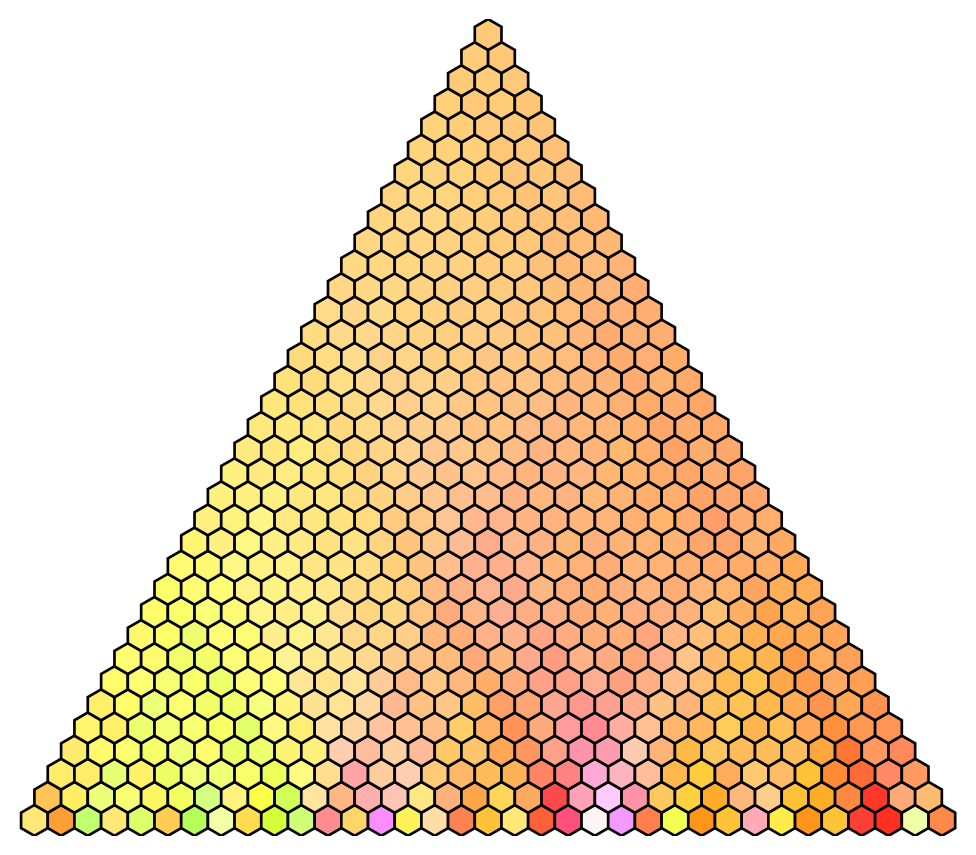

In [18]:
single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5,\
                          aw_size=4, drawing_primitive='hexagon', add_line=1)

### 'True' opacity

Finally, the boolean parameter `output_rgba`, as it names implies, indicates whether the resulting image is in RGBA, or RGB format. By default `output_rgba` is set to the value `False`, meaning the function hardcode a white background for the opacity mapping to be expressed in RGB format during the production of colors. If this parameter is set to `True` then the resulting image is in RGBA format, and the opacity is mapped to the alpha channel, achieving "True opacity".

However because of how matplotlib rasterizes polygons seams appear between the primitives in RGBA mode, even without using the `add_line` parameter. To demonstrate this parameter and the seams produced, here is a code snippet showcasing a wavescape in RGBA mode on a black background: 

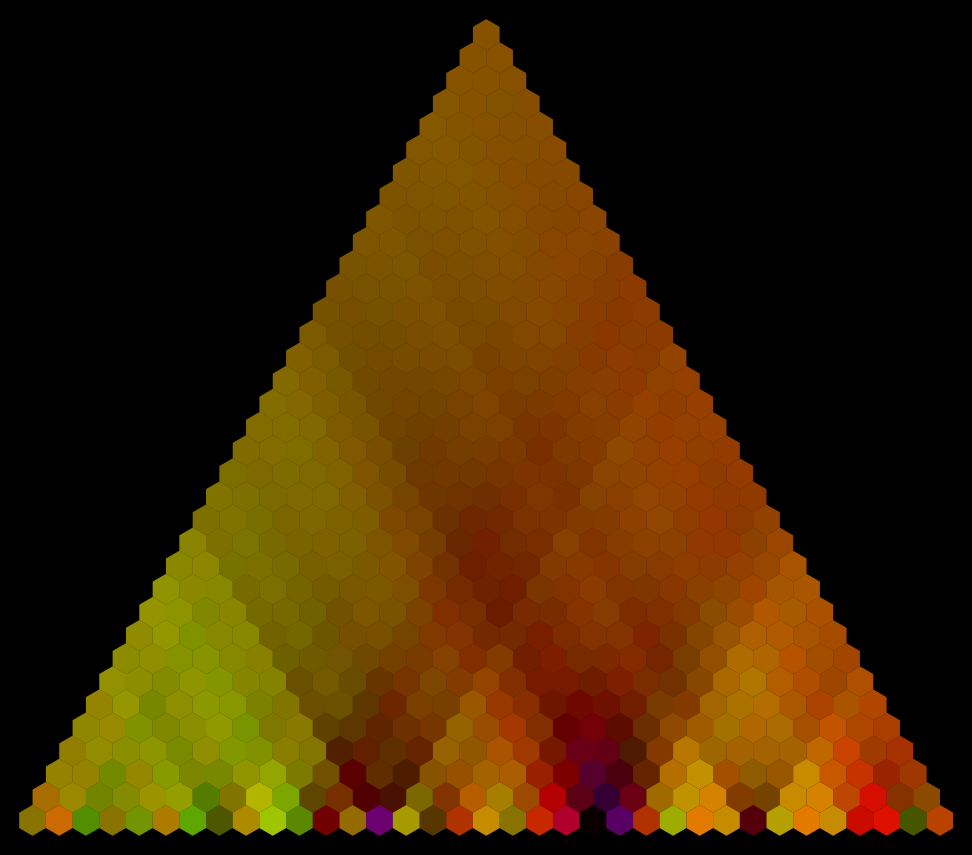

In [19]:
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'black'
single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5,\
                          aw_size=4, drawing_primitive='hexagon', output_rgba=True)

Increasing the width in pixels (`pixel_width`) can mitigate those seams, but we recommand people that uses this parameter to 'embrace' the seams by enabling the `add_line` parameter.

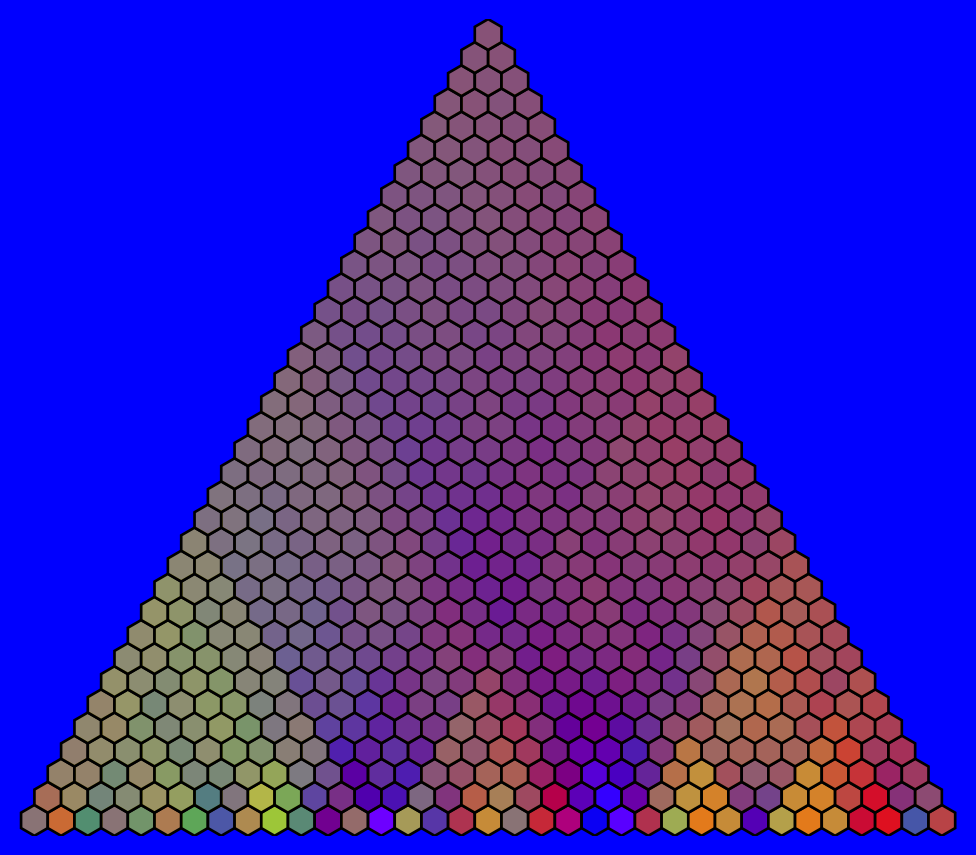

In [20]:
plt.rcParams['figure.facecolor'] = 'blue'
single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5,\
                          aw_size=4, drawing_primitive='hexagon', output_rgba=True, add_line=1)

#reset it to the default background
plt.rcParams['figure.facecolor'] = 'white'

### Labeling the figure and control the size of labels

It is possible to label a wavescape directly on the figure through providing a string value to the `label` parameter. It can be useful for instance to indicate the coefficient visualised in the figure:

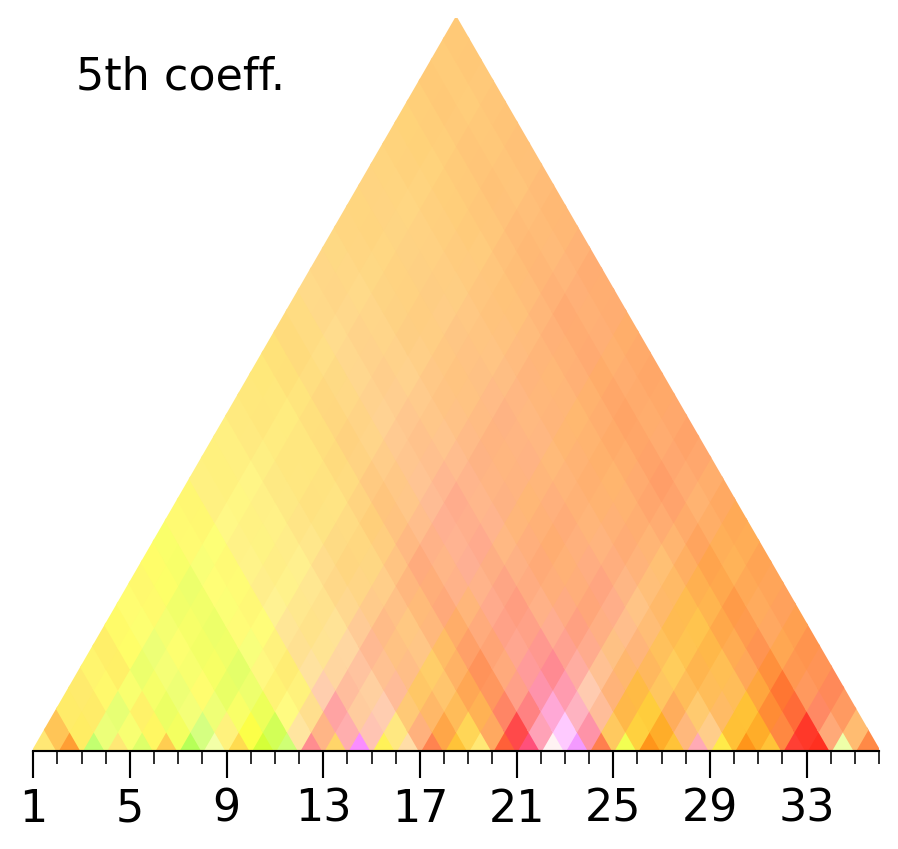

In [21]:
single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5,\
                          aw_size=4, tick_ratio=1, tick_offset=0, label='5th coeff.')

The size of both the label and the tick numbers can be controlled through the `label_size` parameter:

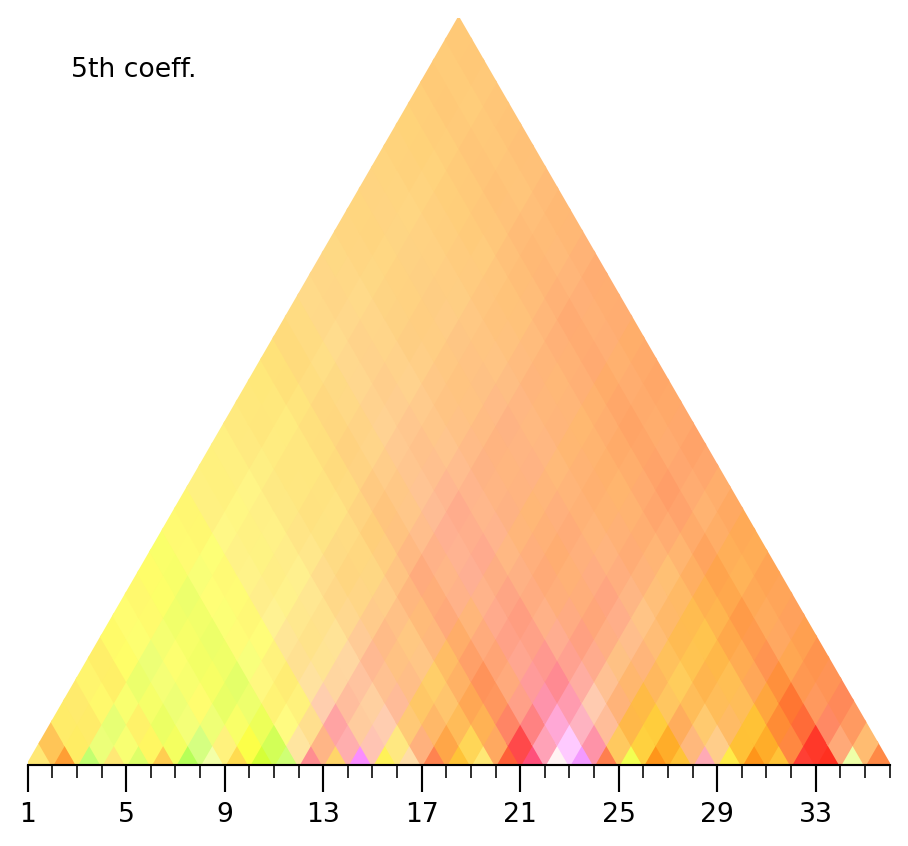

In [22]:
single_wavescape(bach_prelude_fp, pixel_width=500, coefficient=5,\
                          aw_size=4, tick_ratio=1, tick_offset=0, label='5th coeff.', label_size=10)

<a id='other'></a>
# 6. Other parameters

### Saving

All visualisations that can be achieved by this library are produced using `matplotlib`, meaning after any call of the `single_wavescape`, the `matplotlib.pyplot.savefig('<filename>.<format>')` can be used in order to save the plot into any of the image formats supported by matplotlib. Note that if the RGBA mode is enabled by setting `output_rgba=True`, then the `transparent` parameter of the `savefig`function needs to be set to `True`.

However, `generate_single_function` provides a `save_label` parameter that achieve the same result on order to keep everything as a one-liner. `save_label` expects a string value that represent the filepath to save the figure to, and internally calls the `savefig` function using that filepath. The value of `transparent` is automatically set depending on the value of `output_rgba` if this parameters is provided.

```python
#this would saves the plot under the filename 'bache_prelude_5th.png' in the same foldera as this notebook
single_wavescape(bach_prelude_fp, coefficient=5, pixel_width=500, save_label='bache_prelude_5th.png')

```

### Subplots

As the `single_wavescape` uses `matplotlib` for drawing wavescapes, a `maplotlib.pyplot.figure` object can be given through the `ax` parameter in order to build wavescapes in subplots of any other matplotlib figures. Below is an example figure building a histogram of pitch-class distribution in the whole Prelude next to the wavescape of its fifth coefficient:

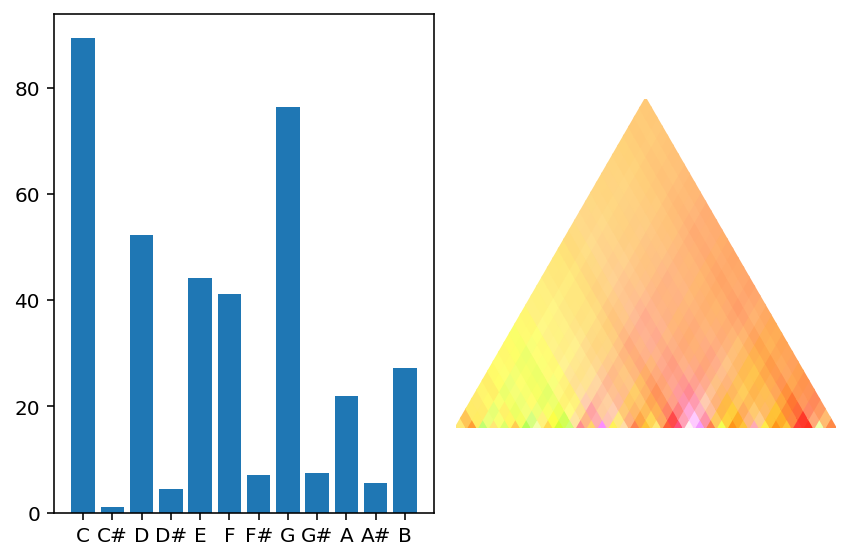

In [23]:
bach_prelude_pcd_y = [89.5, 1., 52.25, 4.5, 44.25, 41.25, 7., 76.5, 7.5, 22., 5.5, 27.25]
pcd_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
bach_prelude_pcd_x = [i for i in range(len(pcd_labels))]


fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.bar(pcd_labels, bach_prelude_pcd_y)
ax2 = fig.add_subplot(1,2,2, aspect='equal')
single_wavescape(bach_prelude_fp, aw_size=4, coefficient=5, pixel_width=700, ax=ax2)

Note that in order to preserve the wavescape proportions without having the hassle to calculate specific height and width of the whole figure, the option `aspect='equal'` of the `subplot` method call should be set.

### Trimming silences

In order to showcase the effect of the next two parameters, a new input file is required. This file is called 'Silences & Percussions' and is a very short score of 5 measures produced for the purpose of this tutorial. It contains two part, a simple melody on the xylophone, and a basic drum beat. Running the cell below displays the score of this short piece:

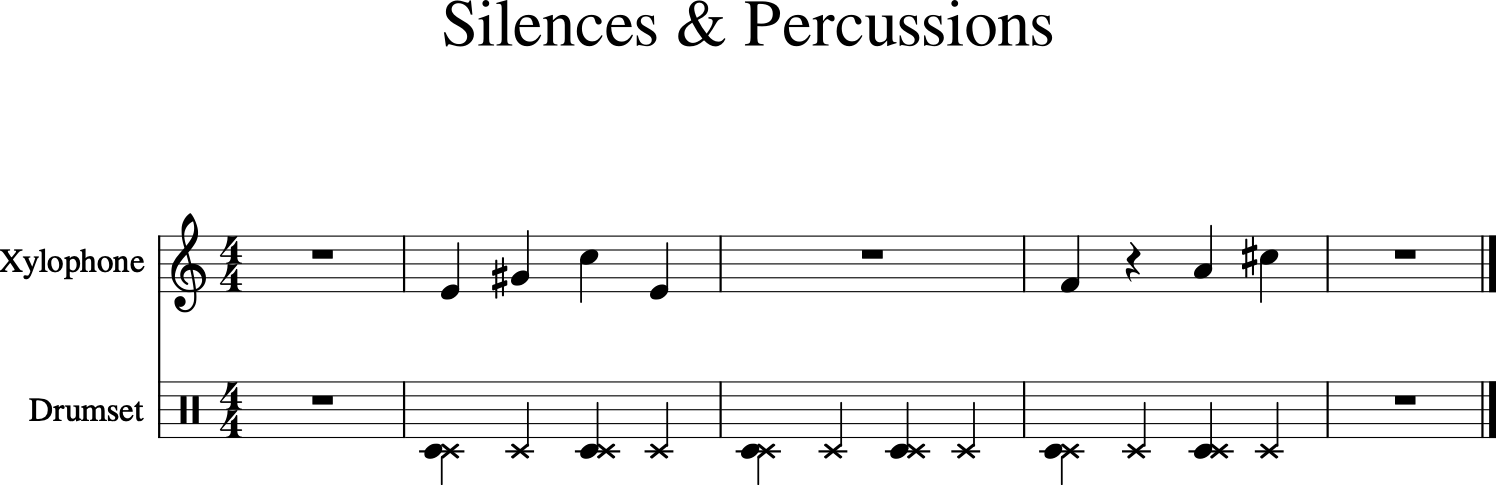

In [24]:
import music21

silence_percu_example_fp = 'inputs/Silences & Percussions.musicxml'
stream = music21.converter.parse(silence_percu_example_fp)
stream.show()

The xylophone part plays note of the C augmented triad on the second bar, and notes of the C# augmented triad on the fourth bar. Thus looking at this example through the wavesape of the 3rd coefficient should display some different bright colors for the second and fourth bar, while being white for the rest of the figure:

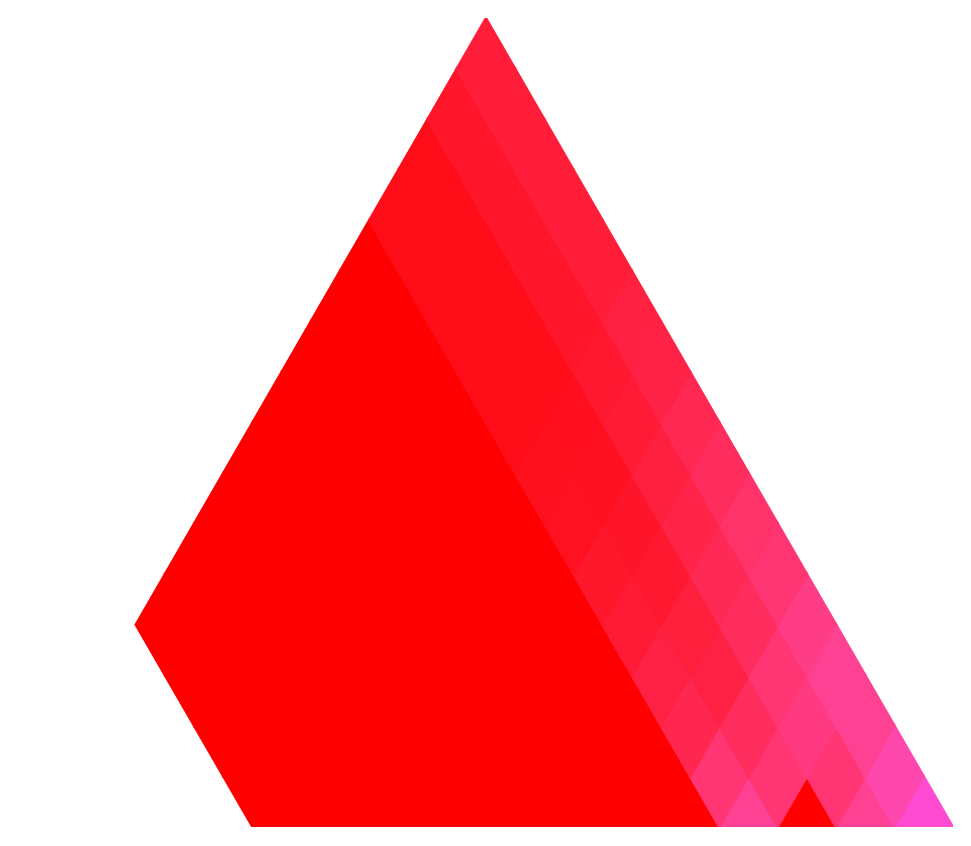

In [25]:
single_wavescape(silence_percu_example_fp, coefficient=3, aw_size=1., pixel_width=500, \
                          trim_extremities=False )

This is not really what was expected, as only one color is predominantly shown instead of the two, and the left-most side of the wavescape do not bring any new information to the plot as it is purely white. As can be seen in the function call above, the parameter `trim_extremities` was set to `False`. This parameter, normally set by default to `True`, removes empty bars before the beginning and after the end of the score. As the pitch class content of such bar is is non existent they do not change the color values from the wavescape. Here is how the wavescape looks like if that parameter is set to `True` or if the parameter is not enabled:

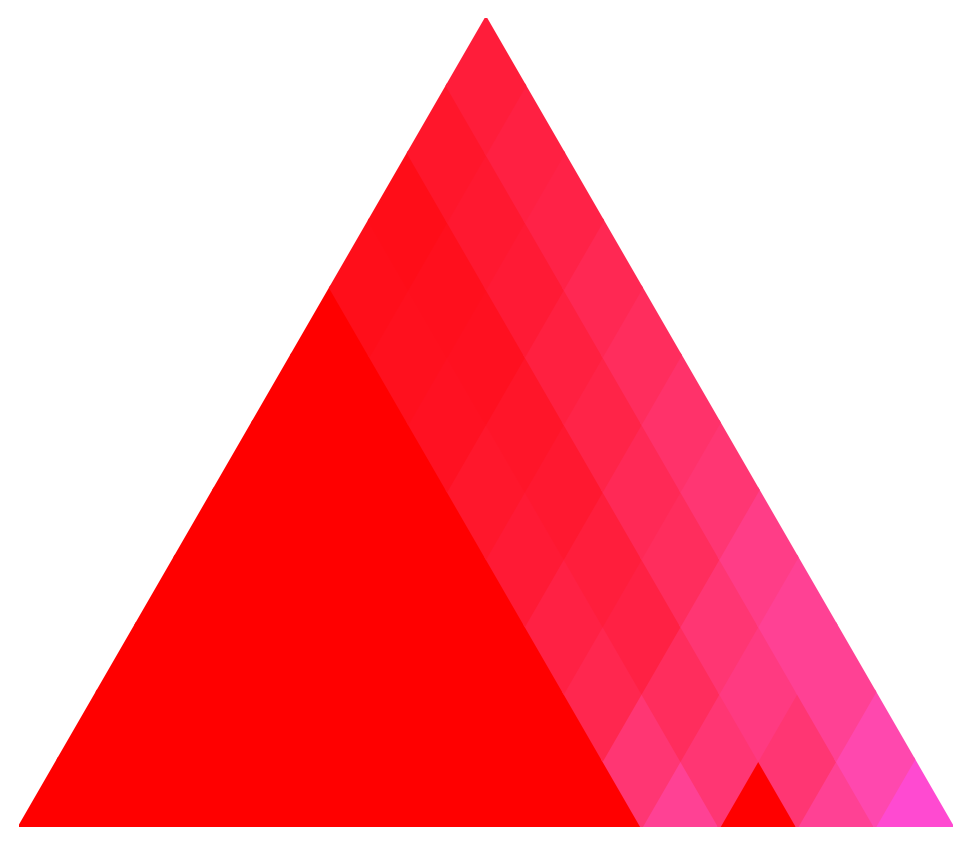

In [26]:
single_wavescape(silence_percu_example_fp, coefficient=3, aw_size=1., \
                          pixel_width=500, trim_extremities=True )

This is better, however, the middle part displays a bright red color although the only pitched instrument, the xylophone does not play during that bar. All of the drum beat happening in this part is actually defaulted to the C pitch in that piece, and thus introduce some unwanted pitch classes in the wavescape. 

### Removing unpitched tracks

Fortunately, the parameter `remove_unpitched_tracks`, a boolean with default value `False`, can be set to `True` in order to filter out all tracks or parts from the input file that do not feature pitched notes:

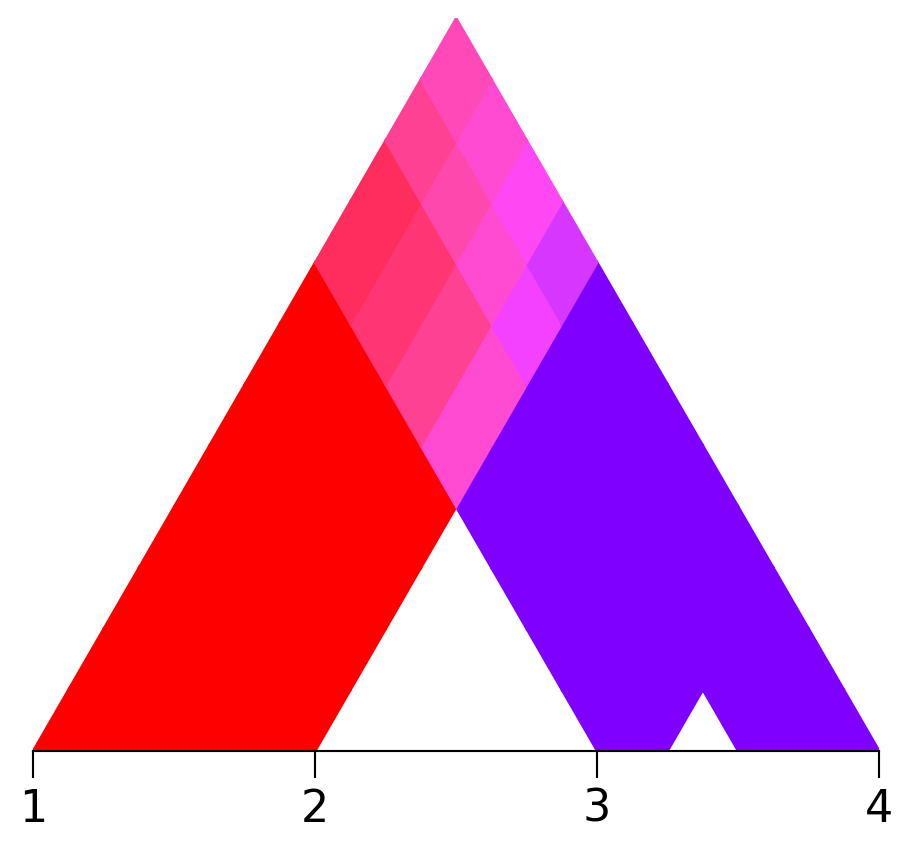

In [27]:
single_wavescape(silence_percu_example_fp, coefficient=3, aw_size=1., \
                          pixel_width=500, tick_ratio=4, tick_offset=0, trim_extremities=True,
                          remove_unpitched_tracks=True)

The final result now resembles what we would expect the xylophone part to look like when it is visualised through the 3rd coefficient.